## Conductancia de Una Diatómica a partir de Funciones de Green

Importamos los módulos de siempre, agregamos una cuadratura Gaussiana para calcular la integral de la función transmisión.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quadrature
import math
%matplotlib inline

Como antes, definimos la Función de Green Superficial del hilo semi-infinito

In [2]:
def myarg(z):
    myarg = math.atan2(z.imag,z.real)
    if (myarg < 0.0):
        myarg = myarg +  2.0 * math.pi
    return myarg

In [3]:
def mysqrt(z):
     return math.sqrt(abs(z)) * (math.cos(myarg(z)/2.0) + (0+1j)*math.sin(myarg(z)/2.0))

In [4]:
def sgwire(z,beta,mu):
    zloc = z
    if ( zloc.imag > 0.0 ):
        return ((zloc-mu) - mysqrt((zloc-mu)**2 - 4.0 * beta**2)) / (2.0 * beta**2)
    else:
        zloc = z.conjugate()
        return (((zloc-mu) - mysqrt((zloc-mu)**2 - 4.0 * beta**2)) / (2.0 * beta**2)).conjugate()

Parámetros generales, $\hbar$, como siempre uno por usar unidades atómicas. Se agrega $\eta$ que usaremos como parte imaginaria cuando correspondan funciones del tipo $G^+$ que requieren un límite para la parte imaginaria que tiende a cero por arriba o debajo. En nuestro caso simplement evaluaremos las funciones apenas por encima o debajo del eje según corresponda. El parámetro $\eta$ controla esa distancia. Debería ser lo más pequeño posible, pero no demasiado para no complicar mucho la integración numérica que deberemos hacer al final.

In [5]:
eta = 0.00001
hbar = 1.0

Los parámetros que definen al sistema:
* $\beta$ es el hopping en los leads
* $\delta$ es el hopping en la diatómica, la diferencia HOMO-LUMO es $|2\delta|$
* $\gamma$ es el acoplamiento de la molécula con los leads
* $\epsilon_1$ y $\epsilon_2$ son energías de sitio en la diatómica y pueden servir para simular una diatómica héteronuclear por ejemplo.

In [6]:
beta = -1.0
delta = -0.25
gamma = -0.1
epsilon1 = 0.0
epsilon2 = 0.0

El Hamiltoniano de la diatómica construído trivialmente elemento a elemento.

In [7]:
H = np.zeros((2,2),dtype=np.complex128)
H[0,0] = epsilon1
H[1,1] = epsilon2
H[0,1] = delta
H[1,0] = delta

Las Self Energies de cada lead, recordemos que son $\Sigma_L(z) = -\gamma^2 G^0_{ll}$. Notemos que dependen del potencial químico de los electrones en cada lado porque este define el centro de la banda.

In [8]:
def Sigma_L(z,mu_l):
    Sigma = np.zeros((2,2),dtype=np.complex128)
    Sigma[0,0] = - gamma**2 * sgwire(z,beta,mu_l)
    return Sigma

In [9]:
def Sigma_R(z,mu_r):
    Sigma = np.zeros((2,2),dtype=np.complex128)
    Sigma[1,1] = - gamma**2 * sgwire(z,beta,mu_r)
    return Sigma

La función de Green del dispositivo es la matriz

$$ G_{\mathrm dev} = \frac{1}{zI-H+\Sigma_L+\Sigma_R} $$

In [10]:
def G_dev(z,mu_l,mu_r):
    return np.linalg.inv(z*np.identity(2) - H + Sigma_L(z,mu_l) + Sigma_R(z,mu_r))

Miremos las densidades de estados de los leads y el dispositivo conectado

In [11]:
dos = []
dos_l = []
dos_r = []
DeltaV = 1.0
mu_l = DeltaV / 2.0
mu_r = - DeltaV / 2.0
energies = np.linspace(-3.0,3.0,1000)
for energy in energies:
    GG = G_dev(energy+eta*1j,mu_l,mu_r)
    dos.append(- (GG[0,0].imag + GG[1,1].imag) / math.pi)
    dos_l.append(- 10.0 * sgwire(energy+eta*1j,beta,mu_l).imag / math.pi)
    dos_r.append(- 10.0 * sgwire(energy+eta*1j,beta,mu_r).imag / math.pi)

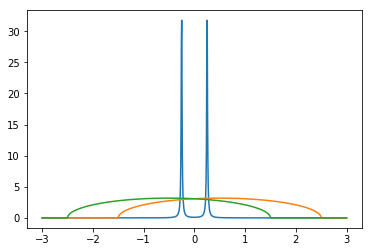

In [12]:
plt.plot(energies,dos)
plt.plot(energies,dos_l)
plt.plot(energies,dos_r)
plt.show()

Definimos los $\Gamma$ de cada lado como $\Gamma = i(\Sigma^+-\Sigma^-)$

In [13]:
def Gamma_L(epsilon,mu_l):
    return (0.0+1j) * ( Sigma_L(epsilon+eta*1j,mu_l) - Sigma_L(epsilon-eta*1j,mu_l) )

In [14]:
def Gamma_R(epsilon,mu_r):
    return (0.0+1j) * ( Sigma_R(epsilon+eta*1j,mu_r) - Sigma_R(epsilon-eta*1j,mu_r) )

Y las $G^+$ y $G^-$ del dispositivo

In [15]:
def G_plus_dev(epsilon,mu_l,mu_r):
    return G_dev(epsilon+eta*1j,mu_l,mu_r)

In [16]:
def G_minus_dev(epsilon,mu_l,mu_r):
    return G_dev(epsilon-eta*1j,mu_l,mu_r)

La función de transmisión es 

$$T(\epsilon)=\mathrm{Tr}[\Gamma_R G_{\mathrm dev}^- \Gamma_L G_{\mathrm dev}^-]$$

es un hecho **importante** que la función de transmisión depende de la diferencia de potencial, en general para voltajes pequeños esta diferencia no es importante pero cuando las diferencias de potencial son grandes podemos tocar los bordes de banda y la transmisión disminuye porque no hay estados en los leads capaces de traer electrones al dispositivo y llevárselos. La función de transmisión es real por definición pero como estamos haciendo jueguitos numéricos (y fundamenalmente por $\eta$) tiene una pequeña parte imaginaria que tiramos.

In [17]:
def T(epsilon,mu_l,mu_r):
    return np.trace(
        np.dot(Gamma_R(epsilon,mu_r),
        np.dot(G_minus_dev(epsilon,mu_l,mu_r),
        np.dot(Gamma_L(epsilon,mu_l),
               G_plus_dev(epsilon,mu_l,mu_r)
              )))
    ).real

In [18]:
transmission = []
mu_l = 0.1
mu_r = -0.1
energies = np.linspace(-1.0,1.0,1000)
for energy in energies:
    transmission.append(T(energy,mu_l,mu_r))

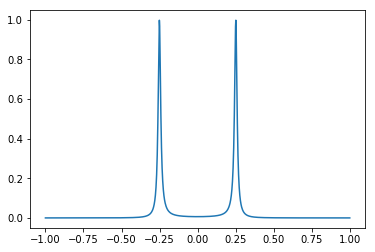

In [19]:
plt.plot(energies,transmission)
plt.show()

La corriente es

$$ I(\Delta V) = \int_{-\Delta V/2}^{\Delta V/2} T(\epsilon,\Delta V)\ d\epsilon $$

In [20]:
def Current(DeltaV):    
    curr = quadrature(T,-DeltaV/2.0,DeltaV/2.0,args=(DeltaV/2,-DeltaV/2),maxiter=400,vec_func=False)[0]
    return 2.0 * curr / (hbar * 2.0 * math.pi)

Lo que sigue es lerdo porque hay que integrar la transmisión a cada bias.

In [21]:
DVs = np.linspace(0.0,1.0,50)
Is = []
for DV in DVs:
    II = Current(DV)
    Is.append(II)

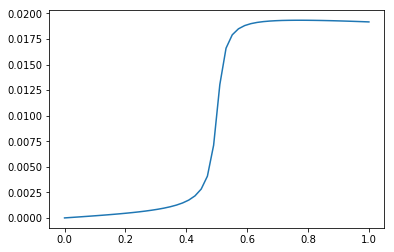

In [22]:
plt.plot(DVs,Is)
plt.show()

Cosas para hacer
* Convertir al sistema en un conductor perfecto y mirar la transmisión y la corriente.
* Fijarse en este paso qué ocurre con la función de transmisión y la corriente en el conductor perfecto cuando aumenta mucho la diferencia de potencial.
* Armar una diatómica y analizar la relación entre las DOS, la T y la curva I vs V
* Jugar con todo lo que se les ocurra! Analizar la influencia de $\gamma$ por ejemplo en las características de la curva IV. Y si cambiamos los $\epsilon_i$?

In [23]:
np.savetxt('deltavs.dat',DVs)
np.savetxt('ivsv.dat',Is)